# Load & Set Up Data

In [44]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
import time
from datetime import timedelta
from scipy import stats
import ast

import cv2 
import contours as ct
 
%load_ext autoreload
%autoreload 2

# image directories
imgdir_toronto_scenes = "../images/data_TorontoScenes/CP_images/" # real images from TorontoScenes dataset
imgdir_SUN397 = "../images/SUN397_IMAGES/" # real images from SUN397 dataset
imgdir_ai_sd= "../images/stableDiffusion_dataset_rev2/IMAGES/" # AI images from stableDiffusion dataset

# scene categories
scene_categories = ['forest', 'highway', 'cockpit', 'bedroom']

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


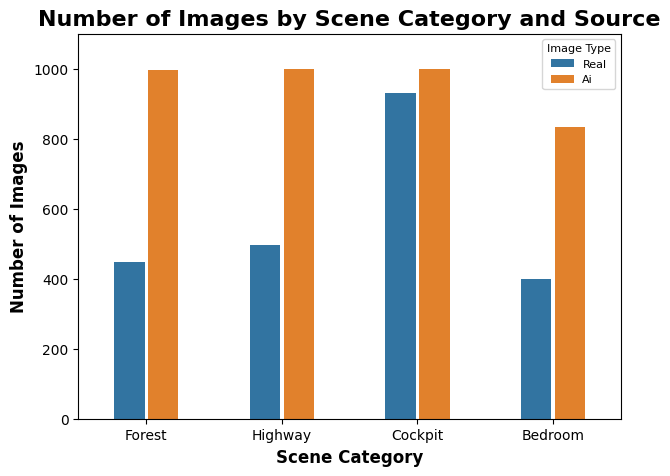

In [2]:
# load images and labels into a dataframe -- use the full file path
imgs_list = glob.glob(f'{imgdir_toronto_scenes}/**', recursive=True) \
            + glob.glob(f'{imgdir_SUN397}/**', recursive=True) \
            + glob.glob(f'{imgdir_ai_sd}/**', recursive=True)
            
image_extensions = ('.jpg', '.jpeg', '.png')
imgs_list = [f for f in imgs_list if os.path.isfile(f) and f.lower().endswith(image_extensions)]
            

# create formatted df with the scene categories and source (ai or real)
df = pd.DataFrame(imgs_list, columns=['img_path'])
df['scene_category'] = df['img_path'].apply(lambda x: next((cat for cat in scene_categories if cat in x.lower()), None))
df['img_type'] = df['img_path'].apply(lambda x: 'ai' if 'stableDiffusion' in x else 'real')
df = df.dropna(subset=['scene_category'])

# show distribution of data
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='scene_category', hue='img_type', width=0.5, gap=0.1)
plt.title('Number of Images by Scene Category and Source', fontsize=16, fontweight='bold')
plt.ylabel('Number of Images', fontsize=12, fontweight='bold')
plt.xlabel('Scene Category', fontsize=12, fontweight='bold')
plt.xticks(ticks=np.arange(4), labels=[cat.capitalize() for cat in scene_categories])
plt.ylim(0, 1100)

# adjust legend fonts
handles, labels = plt.gca().get_legend_handles_labels()
labels = [label.capitalize() for label in labels]
plt.legend(handles, labels, title='Image Type', title_fontsize='8', fontsize='8')


In [3]:
df.sample(10)

,img_path,scene_category,img_type
5608,../images/stableDiffusion_dataset_rev2/IMAGES/...,highway,ai
1621,../images/SUN397_IMAGES/dataset/forest/IMG_004...,forest,real
5748,../images/stableDiffusion_dataset_rev2/IMAGES/...,bedroom,ai
2276,../images/SUN397_IMAGES/dataset/cockpit/IMG_00...,cockpit,real
2984,../images/stableDiffusion_dataset_rev2/IMAGES/...,highway,ai
898,../images/SUN397_IMAGES/dataset/bedroom/IMG_00...,bedroom,real
2882,../images/stableDiffusion_dataset_rev2/IMAGES/...,highway,ai
3040,../images/stableDiffusion_dataset_rev2/IMAGES/...,cockpit,ai
2114,../images/SUN397_IMAGES/dataset/highways/IMG_0...,highway,real
1531,../images/SUN397_IMAGES/dataset/forest/IMG_001...,forest,real


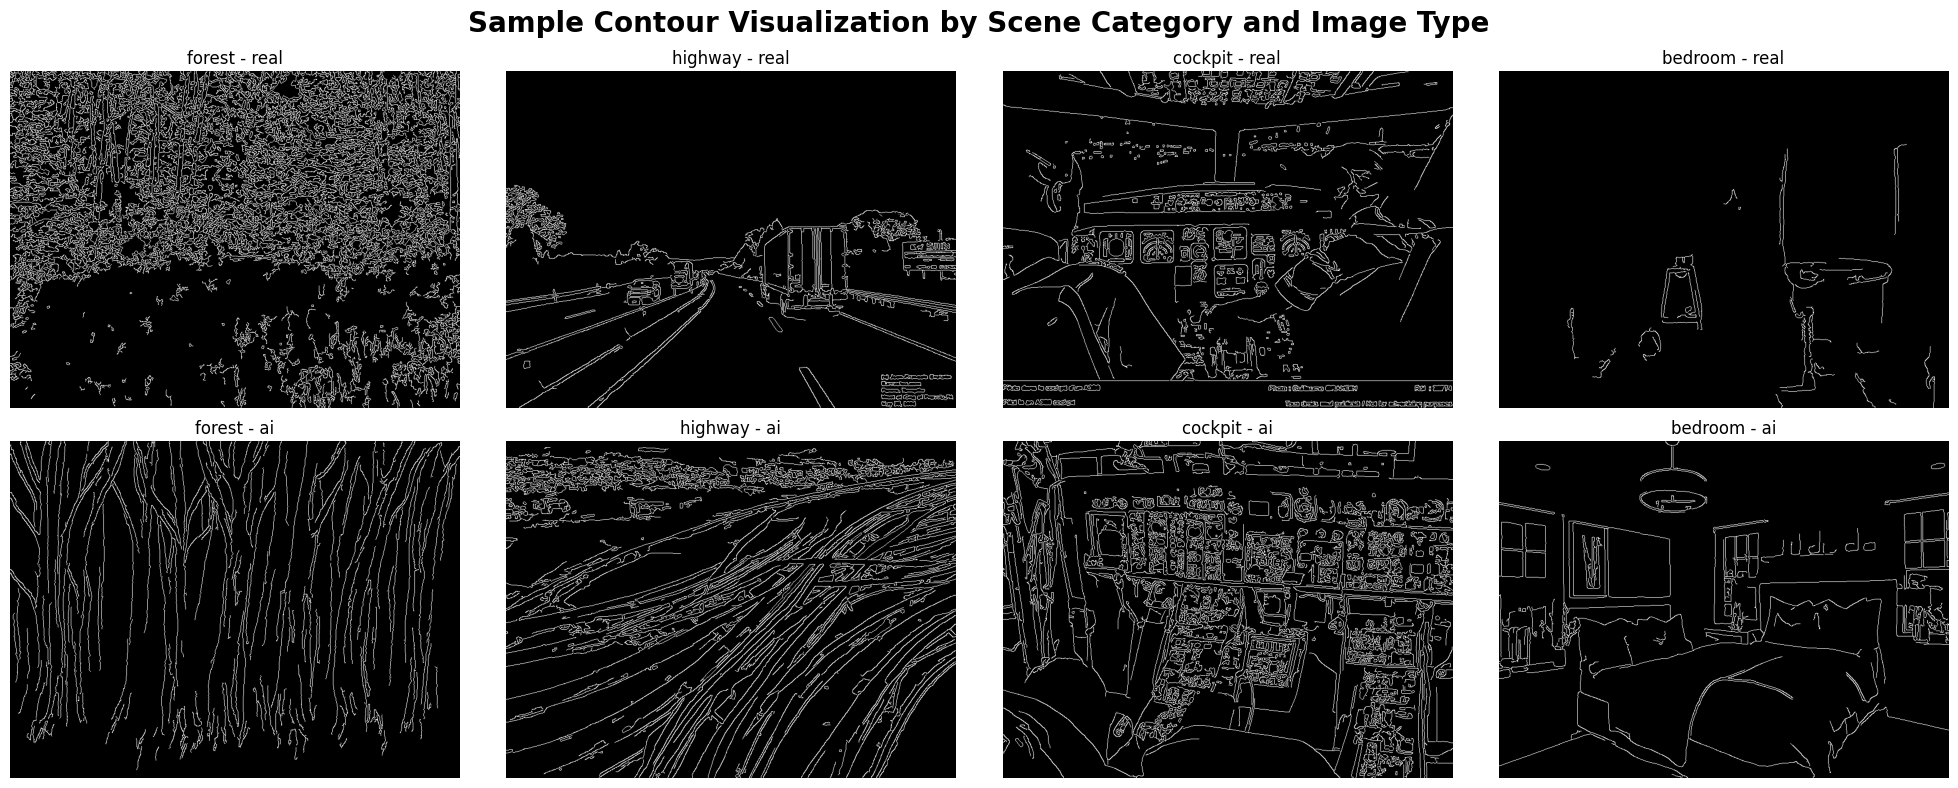

In [4]:
# sample images to show contours
fig, axes = plt.subplots(2, 4, figsize=(20, 8))
fig.tight_layout(pad=3.0)
fig.suptitle('Sample Contour Visualization by Scene Category and Image Type', fontsize=20, fontweight='bold')

for i, img_type in enumerate(['real', 'ai']):
    for j, cat in enumerate(scene_categories):
        
        # Get random sample from this category/type
        sample = df[(df['scene_category'] == cat) & 
                   (df['img_type'] == img_type)].sample(1)
        
        # Get contour image
        contour_img = ct.get_contour_image(sample['img_path'].iloc[0])
        
        # Plot
        axes[i,j].imshow(contour_img, cmap='gray')
        axes[i,j].set_title(f'{cat} - {img_type}')
        axes[i,j].axis('off')

plt.tight_layout()
plt.show()

# Contour Analysis

In [5]:
from multiprocessing import Pool, cpu_count
from functools import partial

def process_single_image(img_path):
    """
    Process a single image and return its metrics.
    
    Args:
        img_path: Path to image file
    Returns:
        dict: Dictionary of computed metrics
    """
    try:
        stats = ct.get_contour_stats(img_path)
        stats['img_path'] = img_path
        stats['status'] = 'success'
        return stats
    except Exception as e:
        return {
            'img_path': img_path,
            'status': 'failed',
            'error': str(e)
        }

def process_images_parallel(df, output_path='contour_metrics.csv', n_processes=None, batch_size=100, max_rows = None):
    """
    Process images in parallel with checkpointing.
    
    Args:
        df: Input dataframe with 'img_path' column
        output_path: Path to save/load checkpoint CSV
        n_processes: Number of parallel processes (default: CPU count - 1)
        batch_size: Number of images to process before saving
    """
    # Load existing results if they exist
    if os.path.exists(output_path):
        existing_results = pd.read_csv(output_path)
        processed_paths = set(existing_results['img_path'].values)
        print(f"Loaded {len(existing_results)} existing results")
    else:
        existing_results = pd.DataFrame()
        processed_paths = set()
        print("Starting new processing")
            
    # Filter unprocessed images
    unprocessed_df = df[~df['img_path'].isin(processed_paths)]
    if len(unprocessed_df) == 0:
        print("All images already processed!")
        return existing_results
    
    # Set up multiprocessing
    if n_processes is None:
        n_processes = max(1, cpu_count() - 1) 
    print(f"Using {n_processes} processes")
    
    # Process in batches
    total_images = len(unprocessed_df)
    start_time = time.time()
    results_list = []
    
    for batch_start in range(0, total_images, batch_size):
        batch_end = min(batch_start + batch_size, total_images)
        batch_paths = unprocessed_df['img_path'].iloc[batch_start:batch_end].tolist()
        
        # Process batch in parallel
        with Pool(n_processes) as pool:
            batch_results = pool.map(process_single_image, batch_paths)
        
        # Filter successful results
        successful_results = [r for r in batch_results if r['status'] == 'success']
        failed_results = [r for r in batch_results if r['status'] == 'failed']
        
        # Create DataFrame from batch results
        if successful_results:
            batch_df = pd.DataFrame(successful_results)
            # Convert orientation_hist to string for CSV storage
            if 'orientation_hist' in batch_df.columns:
                batch_df['orientation_hist'] = batch_df['orientation_hist'].apply(np.array2string)
            
            # Combine with existing results
            if len(existing_results) > 0:
                combined_df = pd.concat([existing_results, batch_df], ignore_index=True)
            else:
                combined_df = batch_df
            
            # Save checkpoint
            combined_df.to_csv(output_path, index=False)
            existing_results = combined_df
        
        # Report progress
        elapsed_time = time.time() - start_time
        images_processed = batch_end
        rate = images_processed / elapsed_time
        
        print(f"Batch {batch_start}-{batch_end} complete. "
              f"Processing rate: {rate:.2f} images/second. "
              f"Failed images in batch: {len(failed_results)}")
        
        if failed_results:
            print("Failed images:")
            for r in failed_results:
                print(f"  {r['img_path']}: {r['error']}")
    
    total_time = time.time() - start_time
    print(f"\nTotal processing time: {timedelta(seconds=total_time)}")
    print(f"Total images processed: {total_images}")
    
    return existing_results

In [6]:
CHECKPOINT_FILE = 'contour_metrics.csv'
N_PROCESSES = 30  # number of threads to use
BATCH_SIZE = 100  

# Process all images
processed_df = process_images_parallel(df, 
                                     output_path=CHECKPOINT_FILE,
                                     n_processes=N_PROCESSES, 
                                     batch_size=BATCH_SIZE)

# merge the processed df with original df 
df = pd.merge(df, processed_df, on='img_path', how='left')

Loaded 6100 existing results
All images already processed!


In [7]:
df

,img_path,scene_category,img_type,num_contours,mean_length,std_length,median_length,orientation_hist,junction_density,parallelism_score,status
0,../images/data_TorontoScenes/CP_images/forests...,forest,real,672,95.719736,150.292787,49.455844,[112 54 38 33 29 28 22 23 34 26 35 ...,49443.750000,0.140192,success
1,../images/data_TorontoScenes/CP_images/highway...,highway,real,81,189.790187,302.560424,89.899495,[17 4 3 0 3 3 2 7 7 10 3 3 0 1 4 ...,4456.250000,0.165123,success
2,../images/data_TorontoScenes/CP_images/forests...,forest,real,1391,120.822118,360.555371,35.213203,[316 153 88 64 69 42 51 46 42 46 37 ...,106656.250000,0.175755,success
3,../images/data_TorontoScenes/CP_images/forests...,forest,real,763,146.412322,272.139140,63.941125,[243 62 24 29 32 25 43 26 15 22 21 ...,56687.500000,0.245042,success
4,../images/data_TorontoScenes/CP_images/forests...,forest,real,1608,69.173510,94.184273,37.798990,[158 87 71 81 87 106 130 130 114 112 87 ...,121970.833333,0.120572,success
...,...,...,...,...,...,...,...,...,...,...,...
6095,../images/stableDiffusion_dataset_rev2/IMAGES/...,bedroom,ai,50,396.402845,445.729219,198.267026,[10 4 2 2 3 1 0 4 5 2 3 2 1 2 0 ...,2087.500000,0.169218,success
6096,../images/stableDiffusion_dataset_rev2/IMAGES/...,highway,ai,140,233.730942,551.664314,43.284271,[22 4 1 1 9 14 14 6 6 11 6 8 16 12 3 ...,7070.833333,0.144641,success
6097,../images/stableDiffusion_dataset_rev2/IMAGES/...,highway,ai,231,198.352382,392.506503,70.911687,[11 7 4 4 48 68 27 29 13 4 2 6 4 2 2 ...,13756.250000,0.314700,success
6098,../images/stableDiffusion_dataset_rev2/IMAGES/...,bedroom,ai,135,230.849940,280.776255,120.468036,[19 1 4 5 3 2 6 15 7 7 14 7 10 1 8 ...,7077.083333,0.129391,success


In [8]:
contour_features = ['num_contours', 'mean_length', 'std_length', 'median_length', 'junction_density', 'parallelism_score']

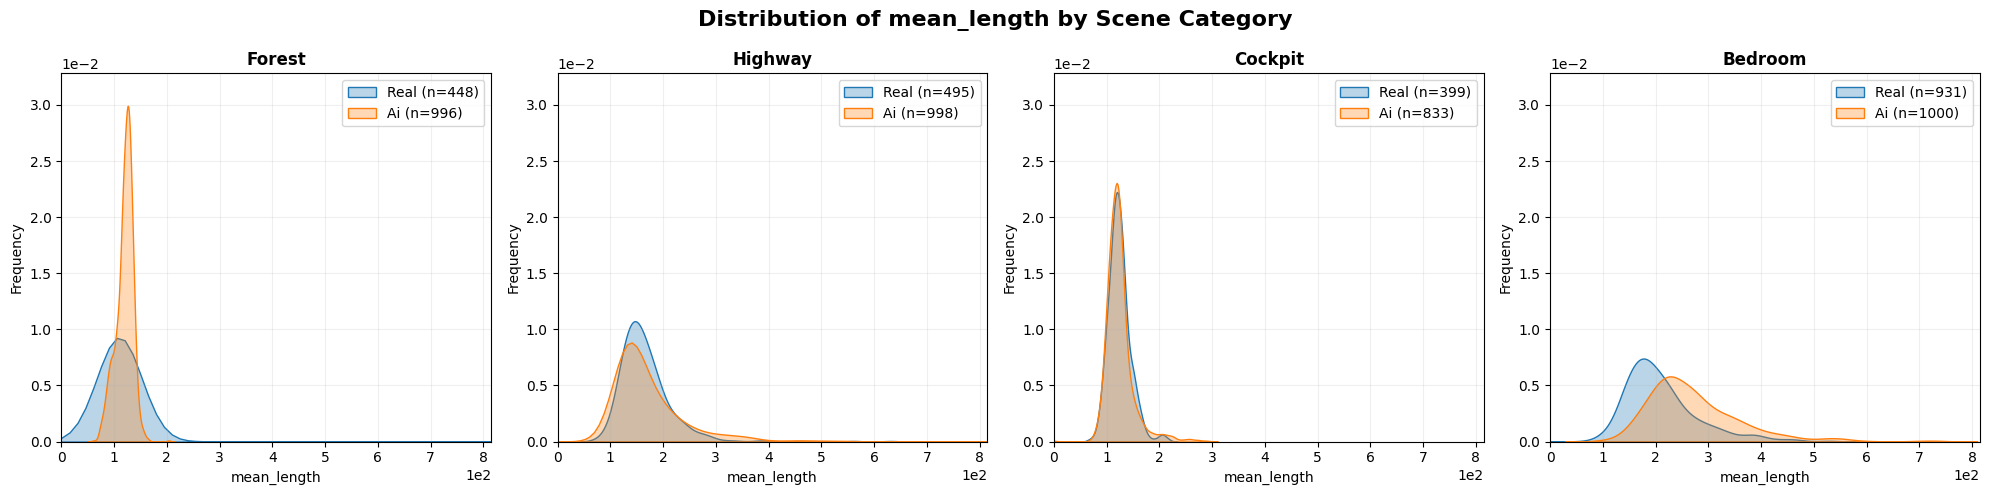

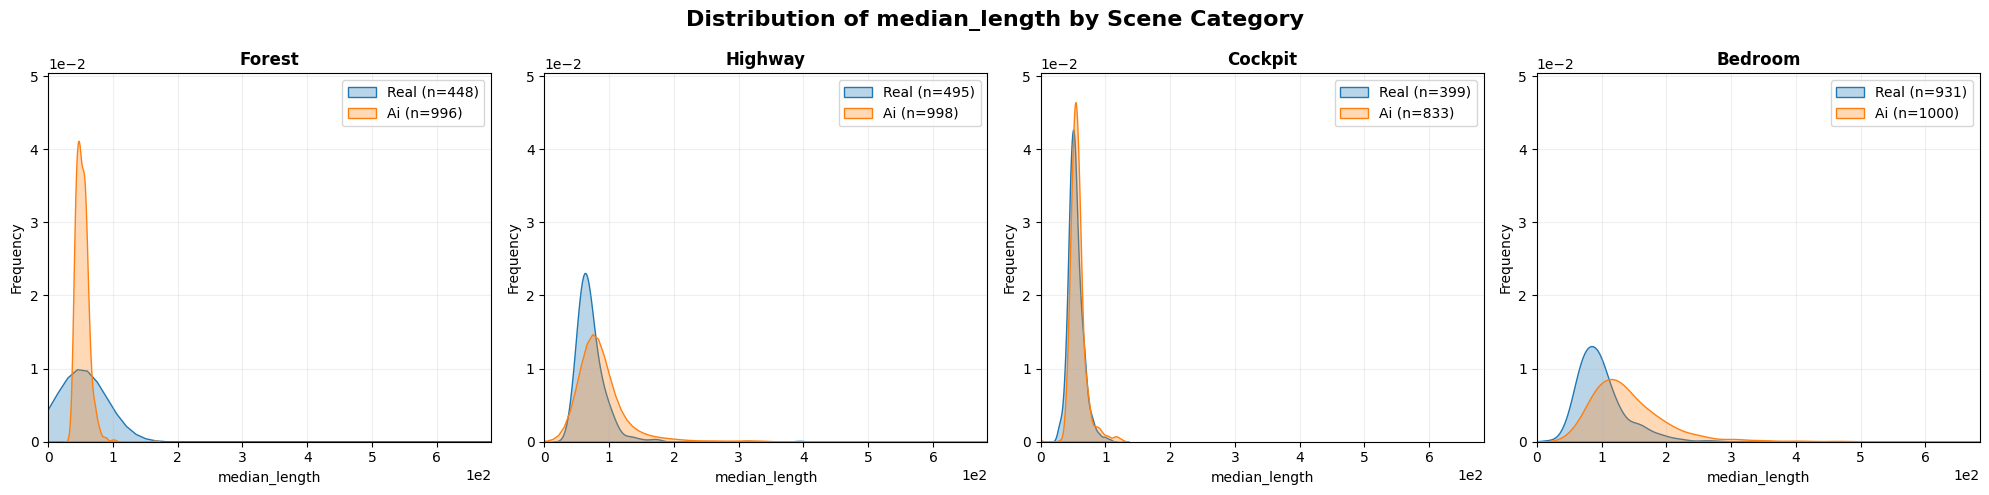

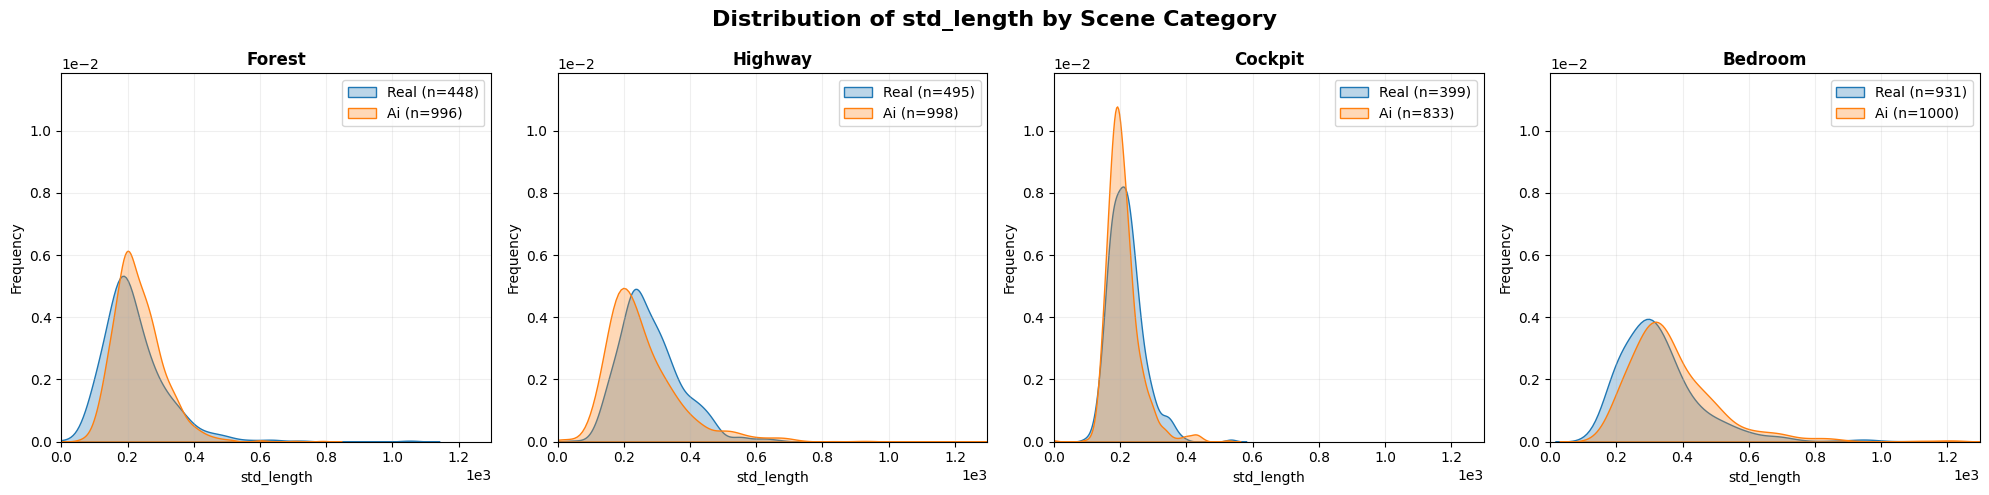

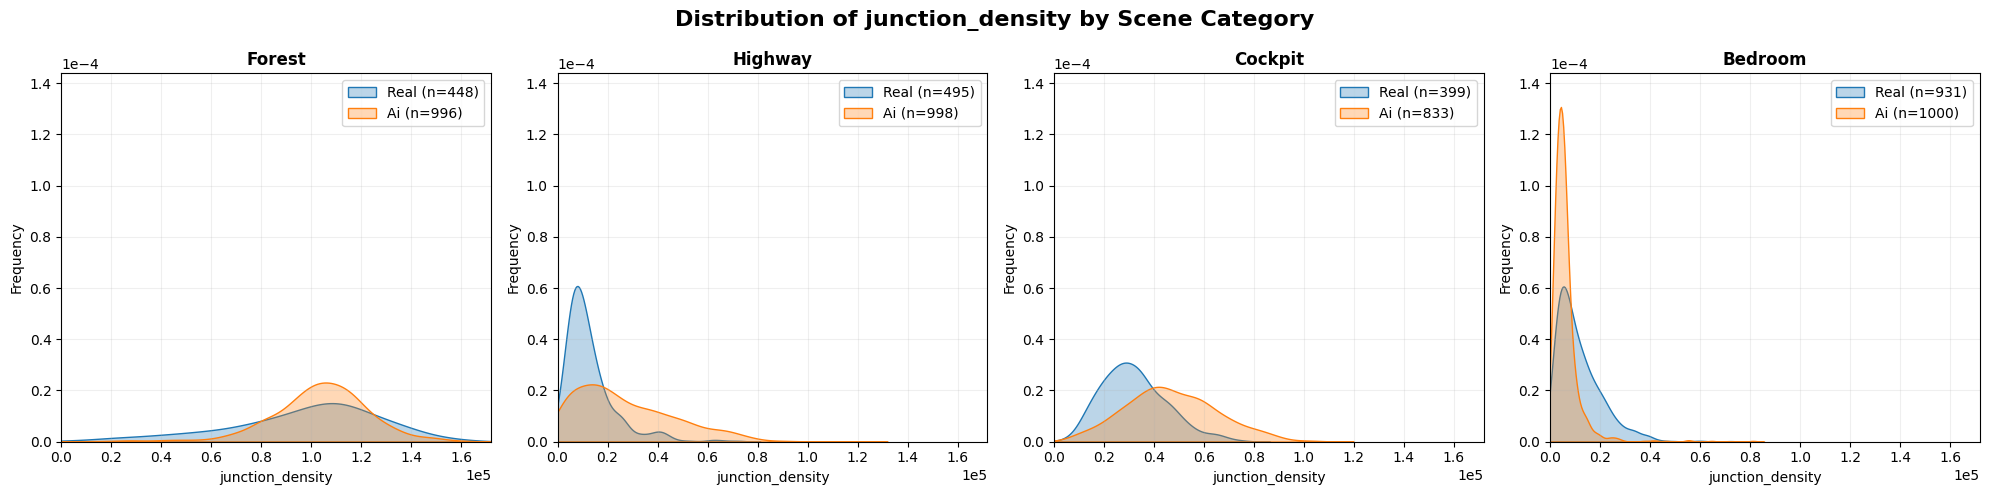

In [57]:
def plot_kde(df, metric_col, figure_size=(20,5)):
    """
    Plot KDE distributions for a given metric across scene categories and image types.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        metric_col (str): Name of column containing metric to plot
        figure_size (tuple): Size of the figure (width, height)
    """
    
    # Create figure and axes
    fig, axes = plt.subplots(1, 4, figsize=figure_size)
    fig.suptitle(f'Distribution of {metric_col} by Scene Category', fontsize=16, fontweight='bold')
    
    # Color scheme
    colors = {'real': '#1f77b4', 'ai': '#ff7f0e'}  # Blue for real, orange for AI
    
    # Find common axis limits across all distributions
    all_values = df[metric_col].dropna()
    xlim_upper = np.percentile(all_values, 99.9) * 1.1  # use upper percentile with 10% padding
    xlim_lower = 0
    
    # Find common y-limit by computing all KDEs first
    max_density = 0
    for cat in scene_categories:
        for img_type in ['real', 'ai']:
            data = df[(df['scene_category'] == cat) & 
                     (df['img_type'] == img_type)][metric_col].dropna()
            if len(data) > 0:
                # Compute KDE manually to get max density
                kernel = stats.gaussian_kde(data)
                x_range = np.linspace(xlim_lower, xlim_upper, 200)
                density = kernel(x_range)
                max_density = max(max_density, np.max(density))
    
    # Plot distributions for each scene category
    for idx, category in enumerate(scene_categories):
        ax = axes[idx]
        
        # Plot KDE for both real and AI images
        for img_type in ['real', 'ai']:
            data = df[(df['scene_category'] == category) & 
                     (df['img_type'] == img_type)][metric_col].dropna()
            
            if len(data) > 0:  # Only plot if we have data
                # Normalize data to account for different sample sizes
                sns.kdeplot(data=data, 
                          ax=ax,
                          color=colors[img_type],
                          label=f'{img_type.capitalize()} (n={len(data)})',
                          fill=True,
                          alpha=0.3)
        
        # Customize subplot
        ax.set_title(category.capitalize(), fontsize=12, fontweight='bold')
        ax.set_xlabel(metric_col)
        ax.set_ylabel('Frequency') # use 'frequency' to avoid confusion with junction density
        ax.set_xlim(xlim_lower, xlim_upper)
        ax.set_ylim(0, max_density * 1.1)  # use padding for visibility
        ax.legend(fontsize=10)
        ax.grid(True, alpha=0.2)

        # scientific notation
        ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
        ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
        
    
    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()
    
for metric in ['mean_length', 'median_length', 'std_length', 'junction_density']:
    plot_kde(df, metric)

In [58]:
def plot_split_violin(df, figure_size=(8, 5)):
    """
    Create a horizontal split violin plot comparing parallelism scores between real and AI images.
    Top half shows real image distribution, bottom half shows AI image distribution.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        figure_size (tuple): Size of the figure (width, height)
    """
    
    # Set up the figure
    plt.figure(figsize=figure_size)
    
    # Create split violin plot
    sns.violinplot(data=df,
                  y='parallelism_score',
                  x='scene_category',
                  hue='img_type',
                  split=True,
                  orient='v',
                  gap = 0.1,  # Reduce the gap between violins
                  inner='quartile',  # Show quartile lines inside violin
                  cut=0,  # Don't extend beyond data range
                  palette=['#1f77b4', '#ff7f0e'], # Blue for real, orange for AI
                  alpha = 0.8
                  )  
    
    # Customize the plot
    plt.title('Distribution of Parallelism Scores by Scene Category', 
             fontsize=16, 
             fontweight='bold',
             pad=20)
    
    plt.ylabel('Parallelism Score', fontsize=12, fontweight='bold')
    plt.xlabel('Scene Category', fontsize=12, fontweight='bold')
    
    # Set x-axis limits with small padding
    plt.ylim(-0.1, 1.1)
        
    # Customize y-axis labels
    plt.xticks(range(len(scene_categories)), 
              [cat.capitalize() for cat in scene_categories],
              fontsize=10)
    
    # Adjust legend
    plt.legend(title='Image Type')
        
    # Add grid for better readability
    plt.grid(True, axis='x', alpha=0.3)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

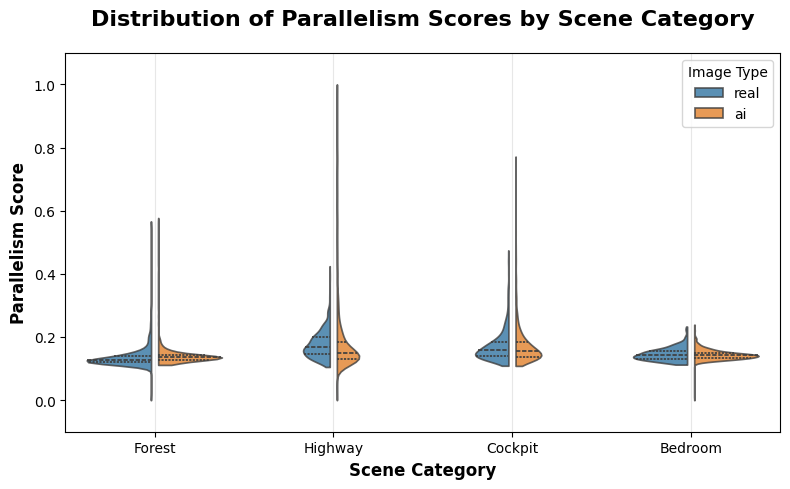

In [12]:
plot_split_violin(df)

In [61]:
def plot_orientations(df, figure_size=(20,5)):
    """
    Plot orientation distributions for each scene category with confidence intervals.
    
    Args:
        df (pd.DataFrame): DataFrame containing the data
        figure_size (tuple): Size of the figure (width, height)
    """
    # Create figure and axes
    fig, axes = plt.subplots(1, 4, figsize=figure_size)
    fig.suptitle('Distribution of Contour Orientations by Scene Category', 
                fontsize=16, fontweight='bold')
    
    colors = {'real': '#1f77b4', 'ai': '#ff7f0e'}
    
    # Bin centers for x-axis (0-180 degrees in 18 bins)
    bin_edges = np.linspace(0, 180, 19)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find common y-limit across all distributions
    max_freq = 0
    min_freq = float('inf')
    
    # First pass to get y-axis limits
    for category in scene_categories:
        for img_type in ['real', 'ai']:
            try:
                # Get all orientation histograms for this category/type
                mask = (df['scene_category'] == category) & (df['img_type'] == img_type)
                hist_arrays = []
                
                # Convert string representations back to arrays and filter valid ones
                for h in df[mask]['orientation_hist'].dropna():
                    try:
                        hist = np.fromstring(h.strip('[]'), sep=' ')
                        if hist.sum() > 0:  # Only keep histograms with non-zero sum
                            hist_arrays.append(hist)
                    except ValueError:
                        continue
                
                if not hist_arrays:
                    continue
                    
                hist_arrays = np.stack(hist_arrays)
                
                # Normalize each histogram by its sum
                sums = hist_arrays.sum(axis=1, keepdims=True)
                hist_arrays = np.divide(hist_arrays, sums, out=np.zeros_like(hist_arrays), where=sums!=0)
                
                # Compute mean and bootstrap confidence intervals
                n_bootstrap = 50
                n_samples = len(hist_arrays)
                bootstrap_means = np.zeros((n_bootstrap, hist_arrays.shape[1]))
                
                for i in range(n_bootstrap):
                    # Resample with replacement
                    indices = np.random.randint(0, n_samples, size=n_samples)
                    bootstrap_means[i] = np.mean(hist_arrays[indices], axis=0)
                
                means = np.mean(hist_arrays, axis=0)
                ci_lower = np.percentile(bootstrap_means, 5, axis=0)
                ci_upper = np.percentile(bootstrap_means, 95, axis=0)
                
                max_freq = max(max_freq, np.max(ci_upper))
                min_freq = min(min_freq, np.min(ci_lower))
                
            except Exception as e:
                print(f"Error processing {category} - {img_type}: {str(e)}")
                continue
    
    # Add padding to y-limits
    y_padding = (max_freq - min_freq) * 0.1
    ylim = (max(0, min_freq - y_padding), max_freq + y_padding)
    
    # Plot distributions for each scene category
    for idx, category in enumerate(scene_categories):
        ax = axes[idx]
        
        # Plot data for both real and AI images
        for img_type in ['real', 'ai']:
            try:
                mask = (df['scene_category'] == category) & (df['img_type'] == img_type)
                hist_arrays = []
                
                for h in df[mask]['orientation_hist'].dropna():
                    try:
                        hist = np.fromstring(h.strip('[]'), sep=' ')
                        if hist.sum() > 0:
                            hist_arrays.append(hist)
                    except ValueError:
                        continue
                
                if not hist_arrays:
                    continue
                    
                hist_arrays = np.stack(hist_arrays)
                
                # Normalize histograms
                sums = hist_arrays.sum(axis=1, keepdims=True)
                hist_arrays = np.divide(hist_arrays, sums, out=np.zeros_like(hist_arrays), where=sums!=0)
                
                # Compute bootstrap confidence intervals
                n_bootstrap = 50
                n_samples = len(hist_arrays)
                bootstrap_means = np.zeros((n_bootstrap, hist_arrays.shape[1]))
                
                for i in range(n_bootstrap):
                    indices = np.random.randint(0, n_samples, size=n_samples)
                    bootstrap_means[i] = np.mean(hist_arrays[indices], axis=0)
                
                means = np.mean(hist_arrays, axis=0)
                ci_lower = np.percentile(bootstrap_means, 5, axis=0)
                ci_upper = np.percentile(bootstrap_means, 95, axis=0)
                
                # Plot mean line
                ax.plot(bin_centers, means, color=colors[img_type], 
                       label=f'{img_type.capitalize()} (n={len(hist_arrays)})',
                       linewidth=2)
                
                # Add confidence intervals
                ax.fill_between(bin_centers, ci_lower, ci_upper,
                              color=colors[img_type], alpha=0.2)
            
            except Exception as e:
                print(f"Error plotting {category} - {img_type}: {str(e)}")
                continue
        
        # Customize subplot
        ax.set_title(category.capitalize(), fontsize=12, fontweight='bold')
        ax.set_xlabel('Orientation (degrees)')
        ax.set_ylabel('Normalized Frequency')
        ax.set_xlim(0, 180)
        ax.set_ylim(ylim)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(np.arange(0, 181, 30))
    
    plt.tight_layout()
    plt.show()

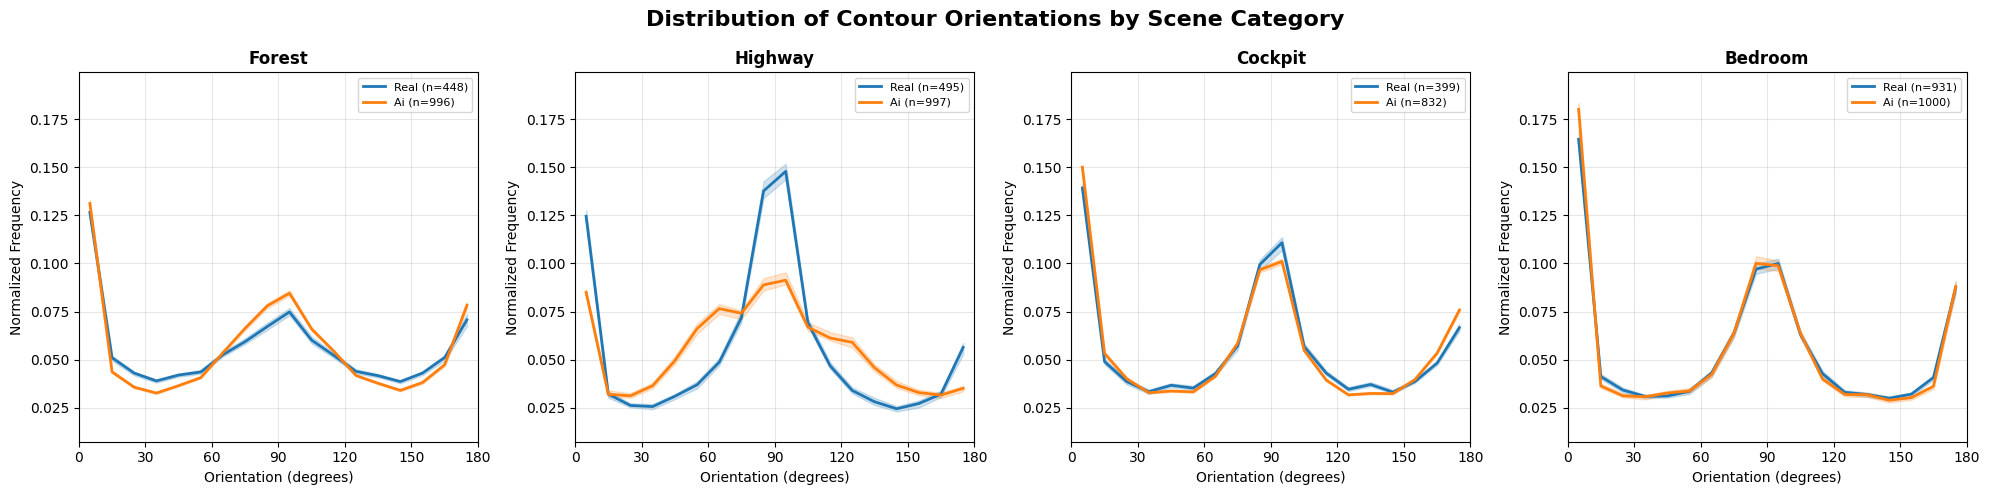

In [62]:
plot_orientations(df)